In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import tensorflow as tf
import h5py

from src.DataPreprocessor.data_preprocessor import DataPreprocessor, Mode
from src.LearningKeras.net_architecture import cnn_150x150x5, cnn_150x150x5_3class
from src.LearningKeras.train import KerasTrainer

from tqdm import trange

np.random.seed(1)
tf.set_random_seed(2)

check data_visualisation for details

In [5]:
from src.DataPreprocessor.DataIOBackend.gdal_backend import GdalBackend
from src.DataPreprocessor.data_visualiser import DataVisualiser

dataiobackend = GdalBackend()
data_preprocessor = DataPreprocessor(data_dir="data/Region 1 - Lopukangri/",
                              backend=dataiobackend,
                              filename_prefix="tibet",
                              mode=Mode.TRAIN,
                              seed=1)

check training for details

In [8]:
model_generator = lambda: cnn_150x150x5_3class()
ensemble_size = 2
batch_size = 5

trainer = KerasTrainer(model_generator=model_generator,
                       ensemble_size=ensemble_size,
                       data_preprocessor=data_preprocessor,
                       batch_size=batch_size)

In [9]:
trainer.models = []
for en in range(ensemble_size):
    model = model_generator()
    model.load_weights('models_joint/model_{}.h5'.format(en))
    trainer.models.append(model)

In [10]:
boxes, avg_fault_probs, avg_lookalike_probs, avg_non_fault_probs = trainer.apply_for_sliding_window_3class_batch(data_preprocessor, stride=50, batch_size=5)

100%|██████████| 793/793 [01:05<00:00, 12.10it/s]


In [11]:

with h5py.File('predicting_tmp_joint.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(boxes))

In [15]:
with h5py.File('predicting_tmp2joint.h5', 'w') as hf:
    hf.create_dataset("dataset",  data=np.array(avg_fault_probs))

In [17]:
with h5py.File('predicting_tmp_joint.h5', 'r') as hf:
    boxes = hf['dataset'][:]
with h5py.File('predicting_tmp2joint.h5', 'r') as hf:
    avg_fault_probs = hf['dataset'][:]

In [18]:
res = trainer.apply_for_sliding_window_heatmaps(boxes, avg_fault_probs, data_preprocessor)

100%|██████████| 3969/3969 [00:00<00:00, 11866.90it/s]


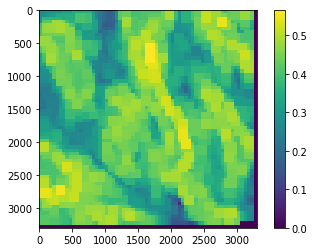

In [19]:
plt.imshow(np.array(res))
plt.colorbar()
plt.show()

In [20]:
cmap = plt.get_cmap('jet')
rgba_img = cmap(res)
rgb_img = np.delete(rgba_img, 3, 2)

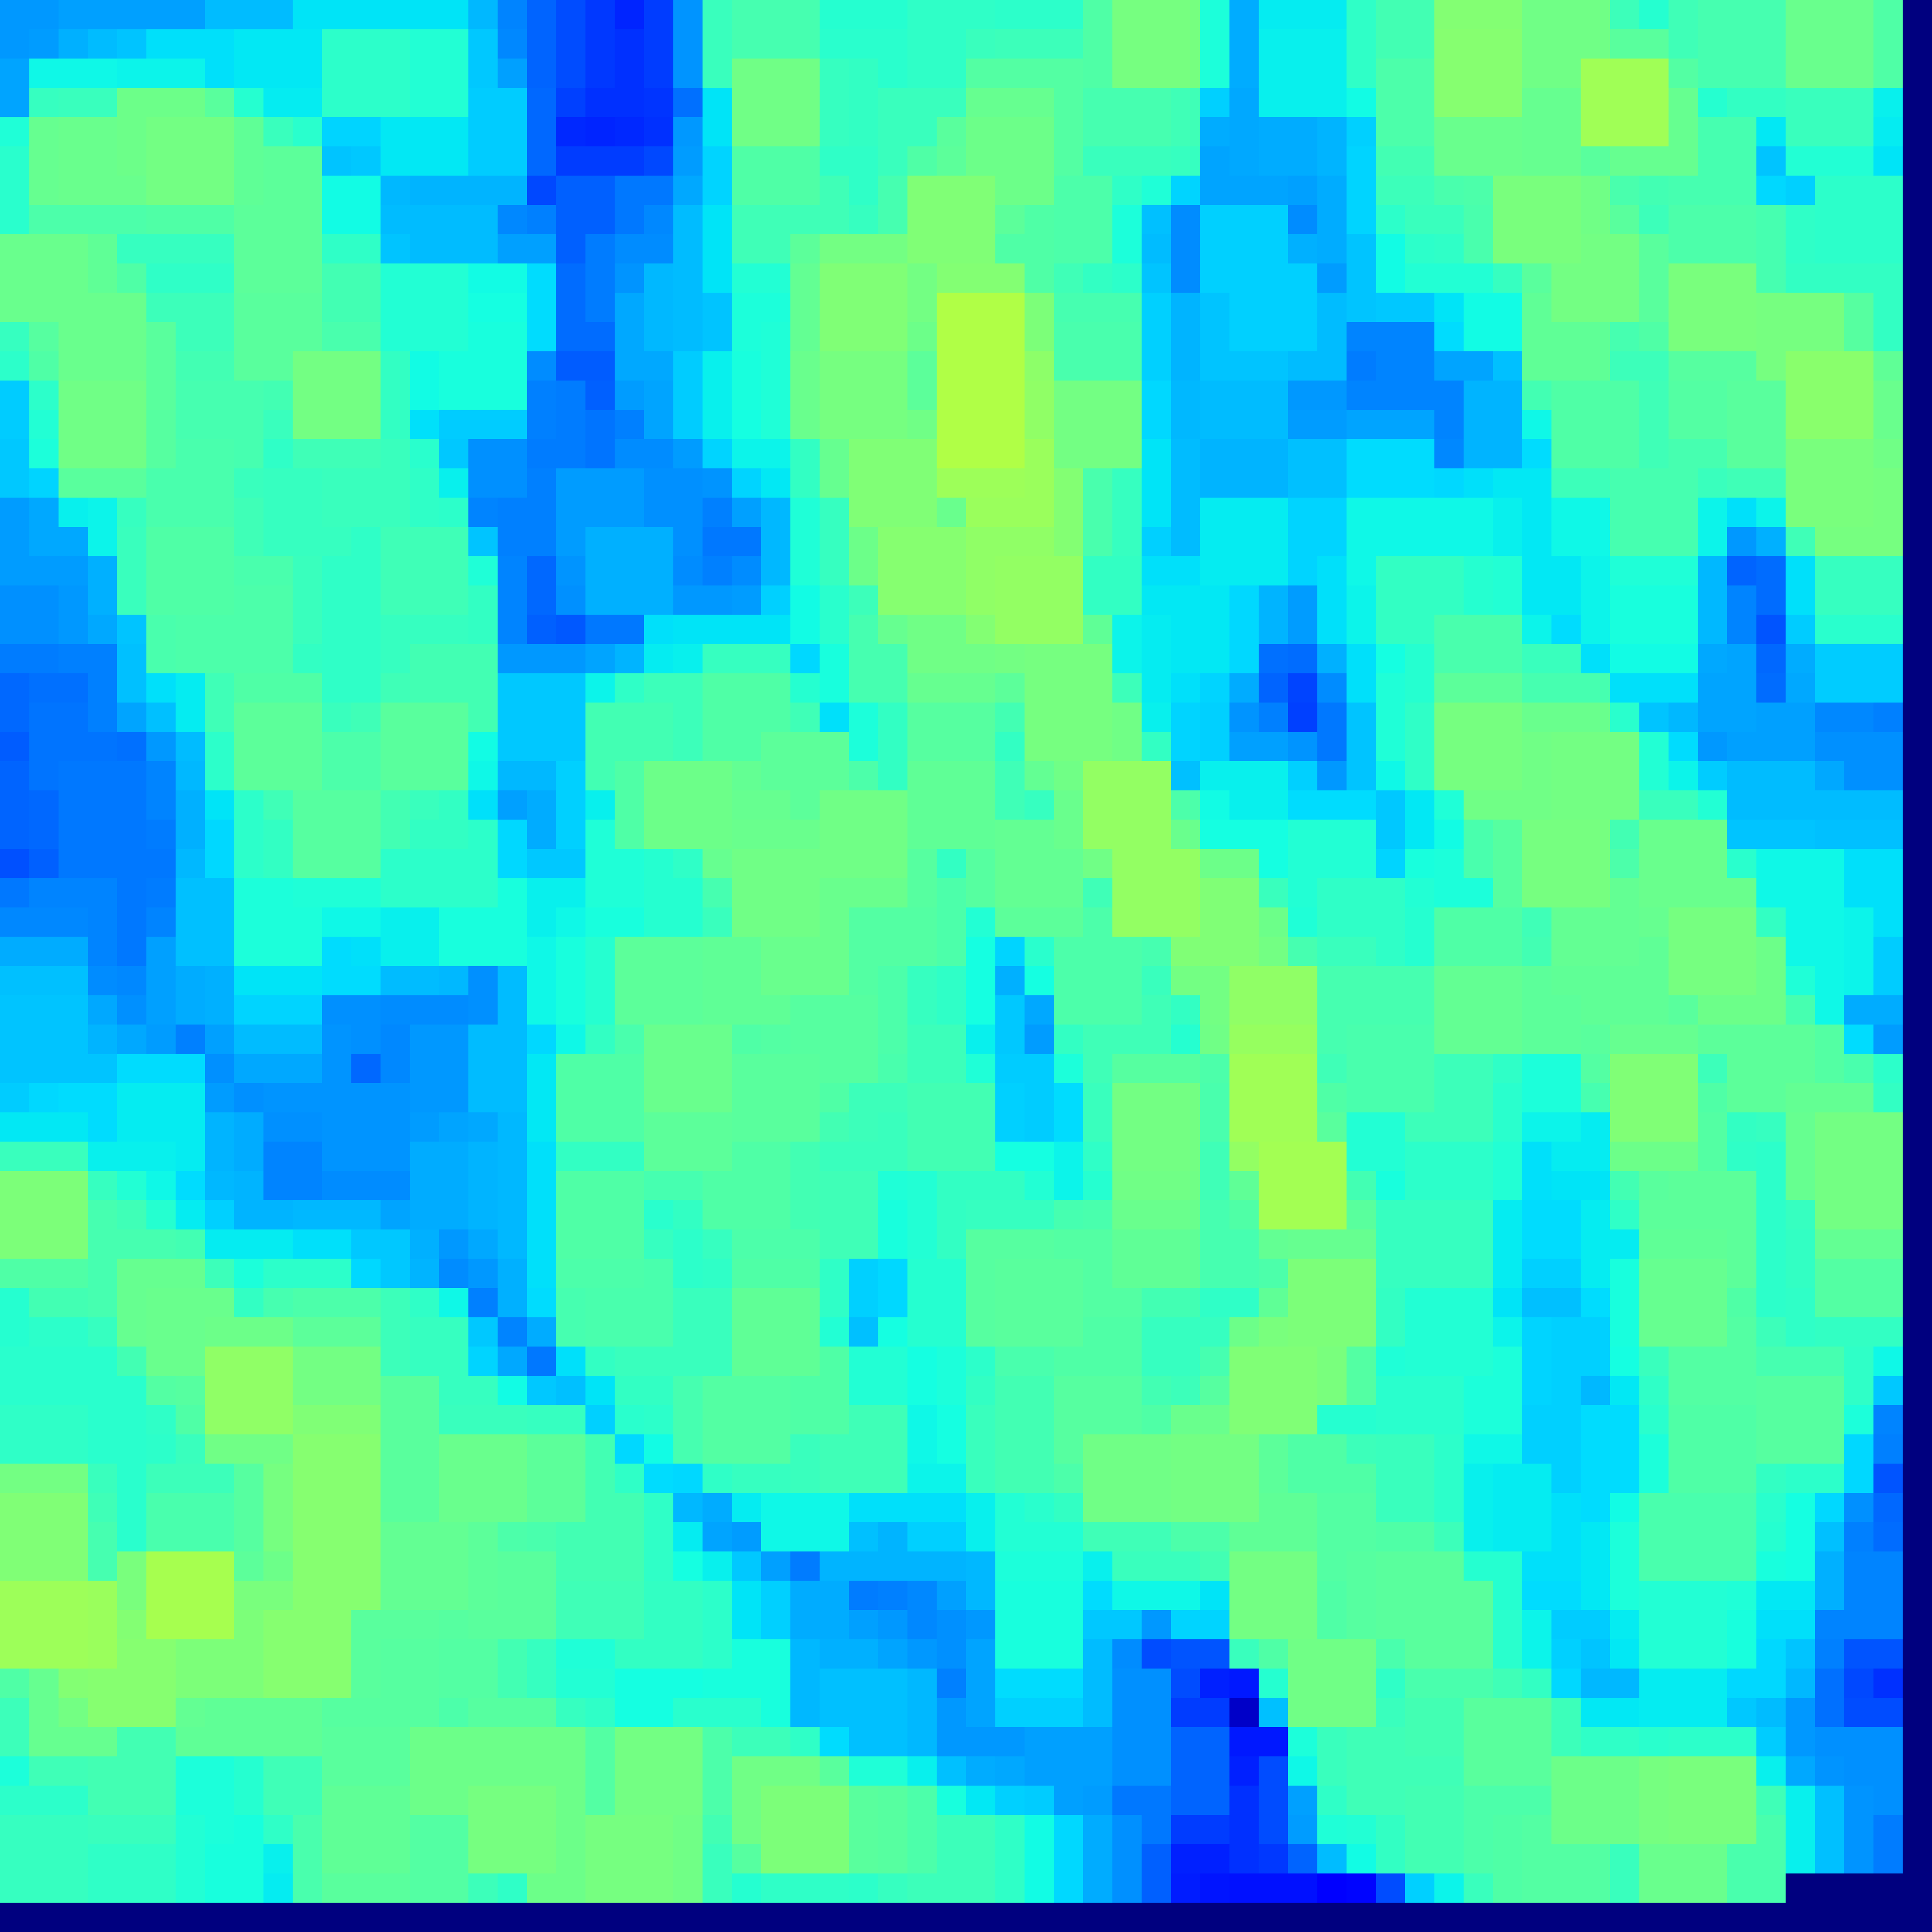

In [21]:
res_im=(rgba_img[:, :, :3] * 255).astype(np.uint8)
Image.fromarray(res_im)

In [22]:
dataiobackend.write_image("heatmaps_3_colours_joint.tif", res_im)